In [25]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Raw Code"></form>''')

# Telco Churn

# Goal: 
* Discover drivers of churn in Telco
* Use drivers to develop a machine learning model 

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

# Acquire

* Data acquired from Codeup SQL Database
* It contained `____` rows and `____` columns before cleaning
* Each row represents a customer
* Each column represents a feature of those customers

# Prepare

**Prepare Actions:**
* Removed columns that did not contain useful information
* Renamed columns to promote readability
* Checked for nulls in the data (there were none)
* Checked that column data types were appropriate
* Removed white space from values in object columns
* Added Target column 'upset' indicating weather the lower rated player won the game
* Added additional features to investigate:
    * Rating Difference
    * Game Rating
    * Lower Rated White
    * Time Control Group
    * Upset
* Encoded categorical variables
* Split data into train, validate and test (approx. 80/20/10), stratifying on 'upset'
* Scaled continuous variable
* Outliers have not been removed for this iteration of the project

# Data Dictionary

In [2]:
%%html
<style>
table {float:left}
</style>

| Feature | Definition |
|:--------|:-----------|
|Churn| Customer leaving the company|
| Total Addons | Number of additional service besides phone and internet|

In [3]:
# acquiring, cleaning, and adding features to data
df = acquire.get_telco_data()
df = prepare.clean_telco_data(df)

# splitting data into train, validate, and test
train, validate, test = prepare.split_telco_data(df)

## A brief look at the data

In [5]:
train.head(3)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6830,9388-ZEYVT,Male,0,No,No,43,No,No phone service,No,No,...,0,0,1,1,0,0,0,0,1,0
433,0635-WKOLD,Male,0,Yes,No,40,Yes,Yes,No,Yes,...,1,0,0,1,0,0,0,1,0,0
25,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,Yes,No,...,0,0,0,0,0,0,0,0,0,0


## A summary of the data

In [6]:
train.describe()

,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
count,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,...,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000
mean,0.163835,32.845803,65.051458,3324.330079,0.497844,0.478062,0.299518,0.901344,0.592696,0.265280,...,0.390566,0.214050,0.394877,0.210500,0.242962,0.442556,0.214050,0.220137,0.339843,0.227999
std,0.370172,24.474291,30.170974,6956.460387,0.500059,0.499582,0.458105,0.298237,0.491395,0.441538,...,0.487939,0.410214,0.488886,0.407715,0.428927,0.496752,0.410214,0.414391,0.473716,0.419595
min,0.000000,0.000000,18.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,36.475000,442.650000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,30.000000,70.200000,1533.800000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,56.000000,90.100000,4229.400000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,72.000000,118.750000,84050.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Explore

## 1. How often does churn occur?

In [7]:
df[df['churn']=="Yes"]['churn'].count()

1869

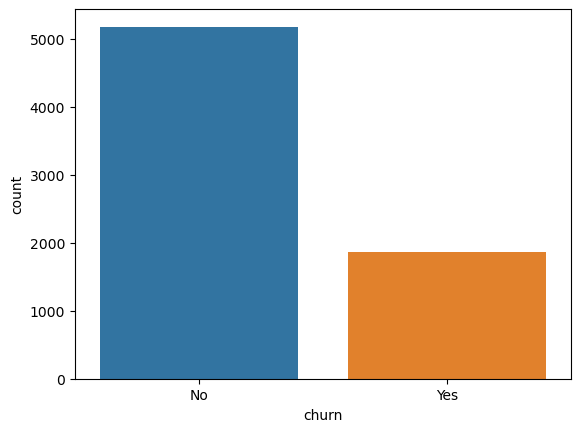

In [8]:
sns.countplot(x=df["churn"])
plt.show()

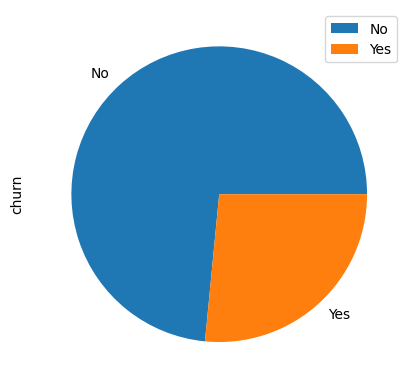

In [9]:
pie=df.groupby(['churn'])['churn'].count().plot(kind='pie', use_index=True, legend=True)
plt.show()

* About 1/3 of the games in the training data will end in upset

## 2. Are senior citizen more likely to churn?

**I will now use a chi-square test to investigate the question of whether `churn` is independent of being a `senior_citizen`.**
* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**- $H_{0}$ (Null Hypothesis): `churn` is independent of being a `senior_citizen`.**

**- $H_{a}$ (Alternative Hypothesis): `churn` is dependent on being a `senior_citizen`.**

In [10]:
group1='senior_citizen'
group2='churn'
observed = pd.crosstab(df[group1], df[group2])
alpha = 0.05
chi2, p, dof, expected = stats.chi2_contingency(observed)
observed_out = observed.values
expected_out = expected.astype(int)
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed_out)

# print --- and then a new line, 'Expected Values', followed by another new line
print('------\nExpected Values\n')

# print the expected values array
print(expected_out)

# print a new line
print('-----\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2: .4f}')

# print the p-value, formatted to a float with 4 digits. 
print(f'p-value = {p: .4f}')
print('Is p-value < alpha?', p < alpha)

prepare.eval_results(p, alpha, group1, group2)

Observed Values

[[4508 1393]
 [ 666  476]]
------
Expected Values

[[4335 1565]
 [ 838  303]]
-----

chi^2 =  159.4263
p-value =  0.0000
Is p-value < alpha? True


'There exists some relationship between senior_citizen and churn. (p-value: 0.0000)'

**Therefore, we have evidence to support that "`senior_citizen`" and "`churn`" are related. Based on this observed in the train data, I believe that using the "`senior_citizen`" feature in modeling will likely have a small positive impact on the model's accuracy.**

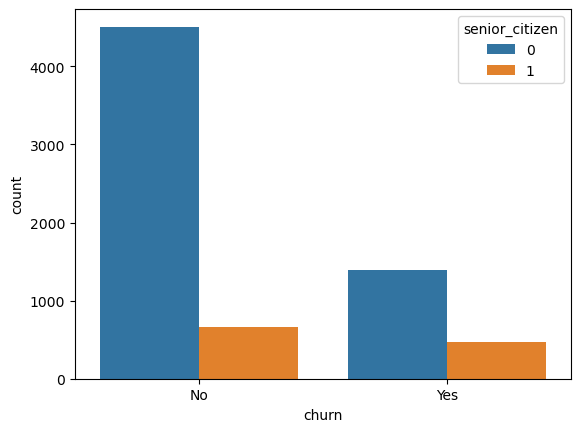

In [26]:
sns.countplot(data=df, x="churn", hue="senior_citizen")
plt.show()

## 3. Does `total_addons` affect churn?

**I will now use a chi-square test to investigate if `total_addons` and `churn` are related.**
We will investigate the question of whether `total_addons` is independent of `churn`.

- $H_{0}$ (Null Hypothesis): `total_addons` is independent of `churn`. 

- $H_{a}$ (Alternative Hypothesis): `total_addons` is dependent on `churn`. 

# created new feature

In [15]:
addons = ['online_security','online_backup','device_protection', 'tech_support', 'streaming_tv','streaming_movies']
addon_sum=(df[addons]=='Yes').sum(axis=1)
df=df.assign(addon_sum=addon_sum)

group1='addon_sum'
group2='churn'

observed = pd.crosstab(df[group1], df[group2])
alpha = 0.05
chi2, p, dof, expected = stats.chi2_contingency(observed)
observed_out = observed.values
expected_out = expected.astype(int)
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed_out)

# print --- and then a new line, 'Expected Values', followed by another new line
print('------\nExpected Values\n')

# print the expected values array
print(expected_out)

# print a new line
print('-----\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2: .4f}')

# print the p-value, formatted to a float with 4 digits. 
print(f'p-value = {p: .4f}')
print('Is p-value < alpha?', p < alpha)

prepare.eval_results(p, alpha, group1, group2)

Observed Values

[[1744  475]
 [ 524  442]
 [ 663  370]
 [ 812  306]
 [ 662  190]
 [ 500   71]
 [ 269   15]]
------
Expected Values

[[1630  588]
 [ 709  256]
 [ 758  274]
 [ 821  296]
 [ 625  226]
 [ 419  151]
 [ 208   75]]
-----

chi^2 =  390.9430
p-value =  0.0000
Is p-value < alpha? True


'There exists some relationship between addon_sum and churn. (p-value: 0.0000)'

**The p-value is less than the alpha. Therefore, we have evidence to support that `addon_sum` and `churn` are related. Based on this observed in the train data, I believe that using the `addon_sum` feature in modeling will likely have a small positive impact on the model's accuracy.**

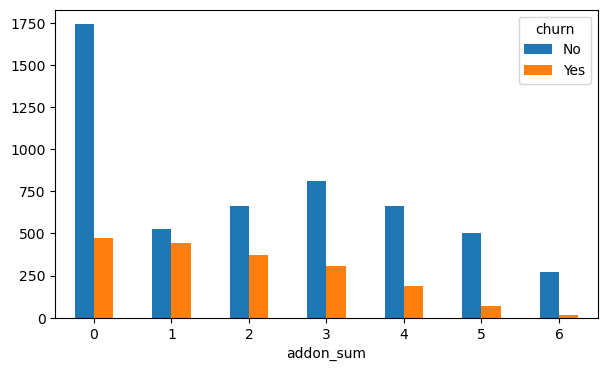

In [20]:
CrosstabResult=pd.crosstab(index=df[group1],columns=df[group2])
CrosstabResult.plot.bar(figsize=(7,4), rot=0)
plt.show()

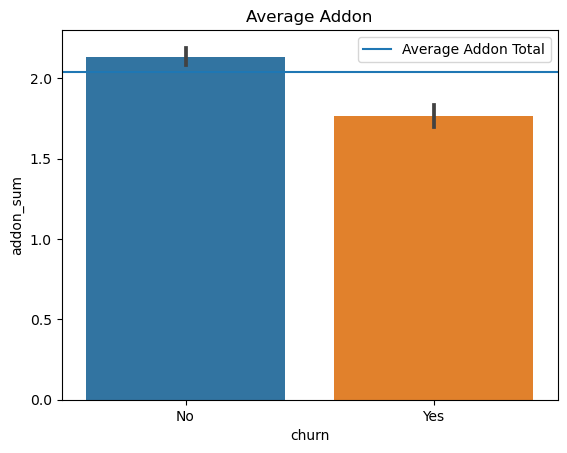

In [17]:
plt.title("Average Addon")
sns.barplot(x="churn", y="addon_sum", data=df)
total_addon_average = df["addon_sum"].mean()
plt.axhline(total_addon_average, label="Average Addon Total")
plt.legend()
plt.show()

## 4. Does `tech_support` affect churn?

**I will now use a chi-square test to investigate if `tech_support` and `churn` are related.**
We will investigate the question of whether `tech_support` is independent of `churn`.

- $H_{0}$ (Null Hypothesis): `tech_support` is independent of `churn`. 

- $H_{a}$ (Alternative Hypothesis): `tech_support` is dependent on `churn`. 

In [21]:
group1='tech_support'
group2='churn'

In [22]:
observed = pd.crosstab(df[group1], df[group2])
alpha = 0.05
chi2, p, dof, expected = stats.chi2_contingency(observed)
observed_out = observed.values
expected_out = expected.astype(int)
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed_out)

# print --- and then a new line, 'Expected Values', followed by another new line
print('------\nExpected Values\n')

# print the expected values array
print(expected_out)

# print a new line
print('-----\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2: .4f}')

# print the p-value, formatted to a float with 4 digits. 
print(f'p-value = {p: .4f}')
print('Is p-value < alpha?', p < alpha)

prepare.eval_results(p, alpha, group1, group2)

Observed Values

[[2027 1446]
 [1413  113]
 [1734  310]]
------
Expected Values

[[2551  921]
 [1121  404]
 [1501  542]]
-----

chi^2 =  828.1971
p-value =  0.0000
Is p-value < alpha? True


'There exists some relationship between tech_support and churn. (p-value: 0.0000)'

**The p-value is less than the alpha. Therefore, we have evidence to support that `tech_support` and `churn` are related. Based on this observed in the train data, I believe that using the `tech_support` feature in modeling will likely have a small positive impact on the model's accuracy.**

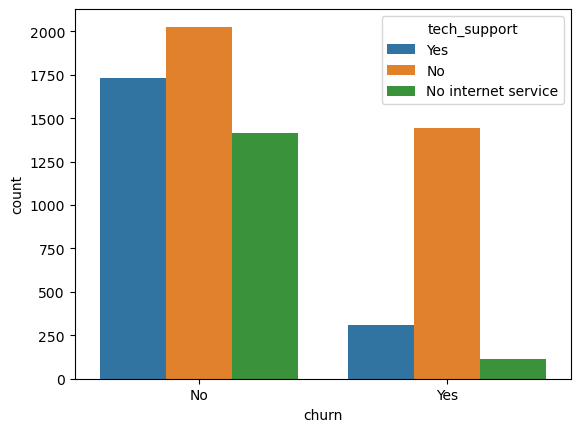

In [23]:
sns.countplot(data=df, x="churn", hue="tech_support")
plt.show()

# Exploration Summary

* "Lower Rated White" and "Rated" were each found to be drivers of "Upset"
    * Though the amount of influence each has is likely to be weak
* "Rating Difference" was found to be a driver of "Upset"
* "Time Control Group" was found to be a driver of "Upsets" 
    * Being in the standard time control or not seemed to have a particularly strong influence.
* "Opening Name" was found to be a driver of "Upsets" 
    * Upset percentage ranged from 20-37%
    * encoding all of these features would result in more noise than signal to the model
    * It may be possible to create groups of similar openings in order to make a more reasonable number features

<br>
* "Game Rating" was not found to be a driver of upsets
<br>

# Features I am moving to modeling With
* "Lower Rated White" (small difference in upset percentage, but relationship to upsets is statistically significant)
* "Rated" (small difference in upset percentage, but relationship to upsets is statistically significant)
* "Time Control standard" (moderate difference in upset percentage, and dependance is statistically significant)
* "Rating Difference" (Large difference in rating observed, and difference is significant)

# Modeling
* I will use accuracy as my evaluation metric  
* non-upsets makeup 67% of the data 
 <br>
* by guessing non-upset for every game one could achieve an accuracy of 67%
* 67% will be the baseline accuracy I use for this project
 <br>
* I will be evaluating models developed using four different model types and various hyperparameter configurations 
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test data 

In [27]:
train, validate, test = prepare.split_telco_data(df)
X_train, y_train = prepare.model_telco_data(train)
X_validate, y_validate = prepare.model_telco_data(validate)
X_test, y_test = prepare.model_telco_data(test)

## Random Forest

In [19]:
# get random forest results
m.get_forest(train_X, validate_X, train_y, validate_y)

Accuracy of Random Forest on train is 0.6726317663817664
Accuracy of Random Forest on validate is 0.6726215205650187


* Random Forest accuracy is about equal to the baseline

## Logistic Regression

In [20]:
# get logistic regression results
m.get_reg(train_X, validate_X, train_y, validate_y)

Accuracy of Logistic Regression on train is 0.6726317663817664
Accuracy of Logistic Regression on validate is 0.6726215205650187


* Logistic regression accuracy is about equal to the baseline


## KNN

In [21]:
# get knn results
m.get_knn(train_X, validate_X, train_y, validate_y)

Accuracy of Logistic Regression on train is 0.6823361823361823
Accuracy of Logistic Regression on validate is 0.6333610303282093


* Logistic regression accuracy is better than baseline on train, and worse than baseline on validate
* It is likely over-fit

# Comparing Models

* Decision Tree, Random Forest, and Logistic Regression models all performed about equal to baseline on train and validate
* The KNN model performed slightly better on train data but was worse on validate data. It is likely overfit.
* Because the results of the Decision Tree, Random Forest, and Logistic Regression models were all very similar I could proceed to test with any of these models.
* I have chosen to move forward with the Logistic Regression model

## Logistic Regression on Test

In [22]:
# get test results for final model
m.get_reg_test(train_X, test_X, train_y, test_y)

Accuracy of Logistic Regression on test is 0.6727318045862413


### Modeling Summary

* Decision Tree, Random Forest, and Logistic Regression models all performed about equal to baseline on train and validate
* The KNN model performed slightly better on train data but was worse on validate data. It is likely overfit.
* A Logistic Regression model selected as the final model and had an accuracy of about 67% which is about equal to the baseline accuracy

# Conclusions

### Exploration

* Upsets in chess occur in about 1/3 of games
* Games in which the lower rated player makes the first move, and games that are rated have a slightly higher chance of ending in an upset 
* Games ending in upset have a much lower mean difference in player rating than games not ending in upset
* Games using shorter time control, such as Bullet, Blitz, and Rapid games, have an upset percentage that closely mirrors the overall upset percentage ranging from 30-34% while standard games have a much lower upset percentage at 22%
* Looking at the top 10 openings in terms of frequency in the data set we can conclude that a given opening does affect the likelihood of a game ending in an upset. Upset percentages very by opening from 20-39%
* The average rating of players in a game has no provable effect on the chance of that game ending in upset

### Modeling

**The final model failed to significantly outperform the baseline. Possible reasons include:**
* “Rated” and “lower rated white” each only accounted for a small difference in the percentage of upsets
* While “Opening Name” seemed to be a significant driver of upsets. It contains 1200+ values that, once encoded, would add an overwhelming number of features to the model. 

### Recommendations

* To increase the skill intensity of a game add to the length of time players are able to consider their moves

### Next Steps
* Cluster together opening variants in "Opening Name" to reduce the number of features input into the model
* Look for other ways to describe "Opening Name" Such as by popularity of the opening or average rating of players playing that opening

# To - Do

# `csv`

In [ ]:
Stats Test  *

In [ ]:
Final Choice
On Test  *

In [ ]:
csv

In [ ]:
Final Notebook *

Only 

In [ ]:
README *

In [ ]:
Presentation

In [ ]:
Improve MVP

In [ ]:
The best feature combo with best Model. Compare to the baseline.
Exploration Takeaways. Statisctics ie 43%